# Lesson 9： Segmentation
- link: https://learn.deeplearning.ai/courses/open-source-models-hugging-face/lesson/10/image-segmentation


## Install the libraries  
- I have to install this libraries before I start. 

In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.24.6-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.7.24-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached safetensors-0.4.4-cp311-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.19.1-cp311-none-win_amd64.whl.metadata (6.9 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
Using cached huggingface_hub-0.24.6-py3-none-any.whl (417 kB)
Using cached regex-2024.7.24-cp311-cp311-win_amd64.whl (269 kB)
Using cached safetensors-0.4.4-cp311-none-win_amd64.whl (285 kB)
Using cached tokenizers-0.19.1-cp311-none-win_amd64.whl (2.2 MB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached anyio-4.4.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Us

## before you start: run this code to configure the logging level of the transformers library (from Hugging Face) to suppress most of the log messages and only display error messages.

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

d:\torch01\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## import the model
- SAM release by Meta AI
- what is pipeline: 
+ The pipeline API abstracts away many of the complexities involved in working with machine learning models, such as tokenization, model loading, preprocessing, and postprocessing. It enables you to perform complex NLP tasks with just a few lines of code, without needing deep knowledge of the underlying models.
+ pipeline provides easy access to a wide variety of pre-trained models for different tasks. 
+ Easy to Use for Prototyping and Quick Experiments


In [5]:
from transformers import pipeline
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

d:\torch01\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Xinji\.cache\huggingface\hub\models--Zigeng--SlimSAM-uniform-77. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# you can also load it like: 
# Load model directly
from transformers import AutoProcessor, AutoModelForMaskGeneration

processor = AutoProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")
model = AutoModelForMaskGeneration.from_pretrained("Zigeng/SlimSAM-uniform-77")

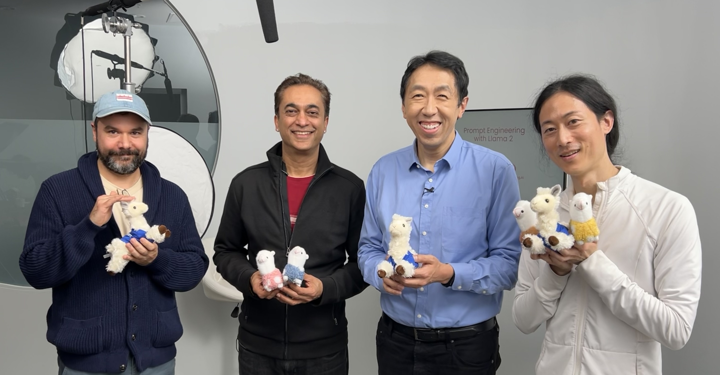

In [7]:
from PIL import Image
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

##using the defined pipeline to do the segmentation task

In [8]:
output = sam_pipe(raw_image, points_per_batch=32)


In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_pipe_masks_on_image(image, masks):
    """
    Display segmentation masks on the input image.
    
    Parameters:
    - image: The raw input image (NumPy array).
    - masks: A list of segmentation masks (NumPy arrays).
    """
    if isinstance(image, str):
        # If the image is a file path, load it
        image = Image.open(image)
        image = np.array(image)  # Convert to NumPy array
    
    # Ensure masks are NumPy arrays
    masks = [np.array(mask) if isinstance(mask, (list, np.ndarray)) else mask for mask in masks]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)

    for mask in masks:
        if mask.shape != image.shape[:2]:
            mask = np.resize(mask, image.shape[:2])
        ax.imshow(mask, cmap='jet', alpha=0.5)
    
    plt.axis('off')
    plt.show()

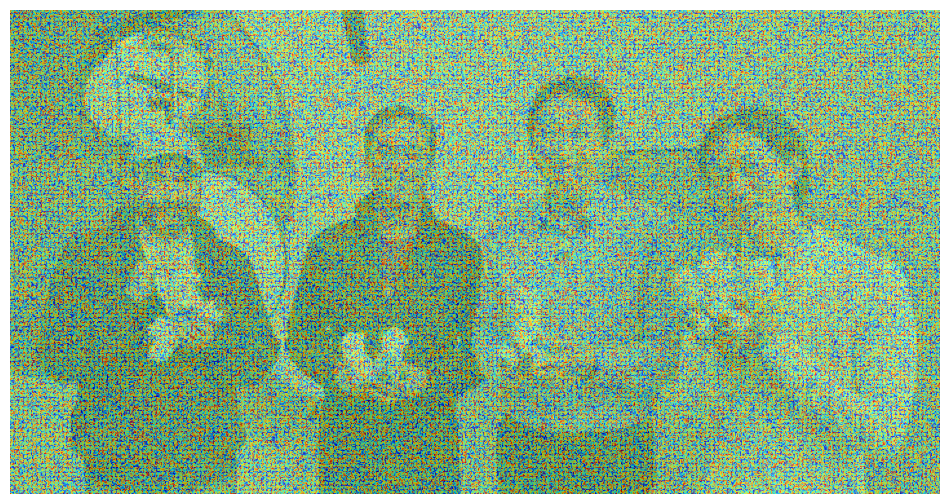

In [16]:
# Example masks (NumPy arrays of the same size as the image)
raw_image = np.array(raw_image)

mask1 = np.random.rand(*raw_image.shape[:2])
mask2 = np.random.rand(*raw_image.shape[:2])

masks = [mask1, mask2]

# Call the function
show_pipe_masks_on_image(raw_image, masks)

## you can also load it like: Faster Inference: Infer an Image and a Single Point

In [17]:
from transformers import SamModel, SamProcessor
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

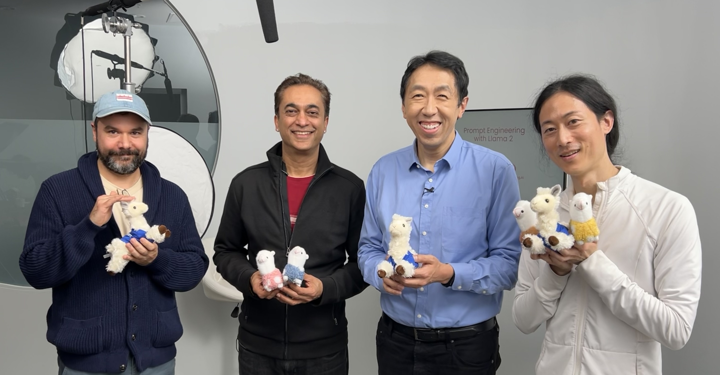

In [20]:
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

- Segment the blue shirt Andrew is wearing.
- Give any single 2D point that would be in that region (blue shirt)

In [21]:
input_points = [[[1600, 700]]]
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")


In [22]:
import torch
with torch.no_grad():
    outputs = model(**inputs)

predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)